In [1]:
%matplotlib notebook
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad

from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "/data/OWN/SF1test/SF0/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False)

loading Dark matter..
loading Stars..
loading Gas..


In [3]:
#ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
#centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
#print "density",centro_rho
#myhalo.center_shift(centro_rho)

cen = myhalo.dm.Clumps.pos3d[myhalo.dm.Clumps.cell==myhalo.dm.Clumps.cell.max()]
myhalo.center_shift(cen)

In [4]:
myhalo.r_virial(600)

| r_200 = 230.2734375
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.439e+12 M_sun
| p_dm_200      =  9.267e+05 particles
| stellar mass  =  1.022e+11 M_sun
| p_st_200      =  4.403e+05 psrticles
| gas mass      =  1.700e+11 M_sun
| p_gs_200      =  2.323e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |17, 0, 0|
| D =| 0,16, 0|
|    | 0, 0, 1|


In [5]:
nucenter = nbe.real_center(myhalo.dm.pos3d, myhalo.dm.mass)
myhalo.center_shift(nucenter)
myhalo.redefine(4.5)

In [6]:
ok,rho_st,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)

In [7]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

# Direct Measurements
## $\rho(r)$


In [8]:
hsml = myhalo.gs.hsml.min()
# R array logarithmic Bining
r_p = np.logspace(np.log10(hsml),np.log10(2.5*myhalo.r200),60)
n_dm,r = np.histogram(myhalo.dm.r,bins=r_p)
vol = np.array([])
r1,r2 =r_p[:-1],r_p[1:]
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
profile = n_dm*myhalo.dm.mass[0]/vol
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.

rr = r

In [9]:
# extra estatistics from Cfalcon density
mean = np.array([])
std = np.array([])
n=np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myhalo.dm.r > r_p[i])&(myhalo.dm.r < r_p[i+1])&(myhalo.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(rho_dm[shell]))
    std = np.append(std,np.std(rho_dm[shell]))

In [10]:
def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator
chi2 = probfit.Chi2Regression(abg_profile, r, profile,std)

In [11]:
m = Minuit(chi2, 
         po=8.0, error_po=0.01,     limit_po=(7.,11.),
         r_s=4.3,    error_r_s=0.01,     limit_r_s=(2.,8.),
         al=1.,     error_al=0.001,    limit_al=(0.1,1.9),
         be=3,  error_be=0.01,   limit_be=(0.01,3.5),
         ga=1,  error_ga=0.0001,   limit_ga=(0,0.25))
m.migrad();

FCN = 11.5962180393 
 TOTAL NCALL = 690 
 NCALLS = 690 
 
 
 EDM = 0.000133264518504 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 8.76868 
 0.400365 
 0 
 0 
 7.0 
 11.0 
 
 
 
 
 2 
 r_s 
 2.00195 
 5.4689 
 0 
 0 
 2.0 
 8.0 
 
 
 
 
 3 
 al 
 1.43198 
 0.661292 
 0 
 0 
 0.1 
 1.9 
 
 
 
 
 4 
 be 
 2.47325 
 0.300817 
 0 
 0 
 0.01 
 3.5 
 
 
 
 
 5 
 ga 
 0.0309662 
 0.22848 
 0 
 0 
 0.0 
 0.25 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 8.769e+00 & 4.004e-01 & & & 7.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 2.002e+00 & 5.469e+00 & & & 2.000e+00 & 8.000e+00 & \\
\hline
3 & al & 1.432e+00 & 6.613e-01 & & & 1.000e-01 & 1.900e+00 & \\
\hline
4 & be & 2.473e+00 & 3.008e-01 & & & 1.000e-02 & 3.500e+00 & \\
\hline
5 & ga & 3.097e-02 & 2.285e-01 & & & 0.000e+00 & 2.500e-01 & \\
\hline
\end{tabular}

$\langle rho \rangle(r) = \frac{1}{N} \sum_i^N \, \rho_i$
$\sigma^2(r) = \frac{1}{N-1} \sum_i^N \, (\rho_i - \langle rho
\rangle(r))^2$.


In [12]:
myhalo.gs.hsml.min()

0.19076478

<IPython.core.display.Javascript object>


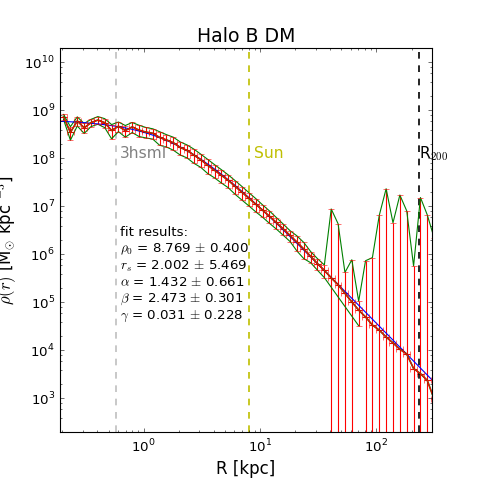

0.399869587562


In [13]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([hsml,300])
ax.set_ylim([2e2,2e10])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
ax.set_title("Halo B DM",fontsize=17)
#horizontal lines
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhalo.r200,c='k',linestyle='--',lw=1.5) #r200
#define sigma pluss and sigma minus lines
mean_plus = profile+std
mean_minu = profile-std
#  plot things
#ax.scatter(myhalo.dm.r,rho_dm,s=0.02,lw=0,alpha=0.6,c='#FF9100')
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')

ax.plot(r_p,abg_profile(r_p,m.values['po'] ,m.values['r_s'],m.values['al'],m.values['be'],m.values['ga']))
#plot means
ax.plot(r,profile,lw=1.5)
ax.errorbar(r,profile,xerr=bin_size,yerr=std)

expected = abg_profile(r,m.values['po'] ,m.values['r_s'],m.values['al'],m.values['be'],m.values['ga'])
observed = profile
c = (observed- expected)**2 / std**2
print np.sum(c)/29
texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["po"],m.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["r_s"],m.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["al"],m.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["be"],m.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["ga"],m.errors["ga"])+"\n"

fig.text(0.25,0.3,texto,fontsize=12)
ax.text(3*hsml*1.1,1e8,"3hsml",color='gray',fontsize=14)
ax.text(8*1.1,1e8,"Sun",color='y',fontsize=14)
ax.text(myhalo.r200*1.01,1e8,r"R$_{200}$",color='k',fontsize=14)


#  Sanity check

In [14]:
def chi2(po,r_s,al,be,ga):
    chi2_array =np.array([])
    expected = abg_profile(r,po,r_s,al,be,ga)
    observed = profile
    c = ((observed)- expected)**2 / std**2
    chi2_array = np.append(chi2_array,c)
    return np.nansum(chi2_array)

In [15]:
m_SC = Minuit(chi2, 
         po=8.0, error_po=0.01,     limit_po=(7.,11.),
         r_s=4.3,    error_r_s=0.01,     limit_r_s=(2.,8.),
         al=1.,     error_al=0.001,    limit_al=(0.1,8),
         be=3,  error_be=0.01,   limit_be=(0.01,3.5),
         ga=1,  error_ga=0.0001,   limit_ga=(0.5,1))
m_SC.migrad();

FCN = 16.2873677462 
 TOTAL NCALL = 486 
 NCALLS = 486 
 
 
 EDM = 2.08182282737e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 8.28593 
 0.0447224 
 0 
 0 
 7.0 
 11.0 
 
 
 
 
 2 
 r_s 
 2.667 
 0.420586 
 0 
 0 
 2.0 
 8.0 
 
 
 
 
 3 
 al 
 2.98976 
 1.24365 
 0 
 0 
 0.1 
 8.0 
 
 
 
 
 4 
 be 
 2.31672 
 0.142429 
 0 
 0 
 0.01 
 3.5 
 
 
 
 
 5 
 ga 
 0.5 
 0.029481 
 0 
 0 
 0.5 
 1.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 8.286e+00 & 4.472e-02 & & & 7.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 2.667e+00 & 4.206e-01 & & & 2.000e+00 & 8.000e+00 & \\
\hline
3 & al & 2.990e+00 & 1.244e+00 & & & 1.000e-01 & 8.000e+00 & \\
\hline
4 & be & 2.317e+00 & 1.424e-01 & & & 1.000e-02 & 3.500e+00 & \\
\hline
5 & ga & 5.000e-01 & 2.948e-02 & & & 5.000e-01 & 1.000e+00 & \\
\hline
\end{tabular}

In [16]:
Pcrit = myhalo.dm._p.rho_crit
Mdm = myhalo.dm.mass.min()
myradiuses = myhalo.dm.r[np.argsort(myhalo.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03

1.74888899313


In [17]:
print myhalo.gs.hsml.min()

0.190765


<IPython.core.display.Javascript object>


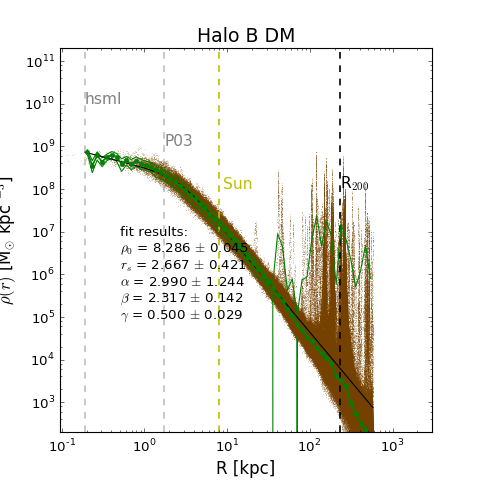

In [18]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([hsml/2.,3000])
ax.set_ylim([2e2,2e11])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
ax.set_title("Halo B DM",fontsize=17)
#horizontal lines
ax.axvline(x=R_P03,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=myhalo.gs.hsml.min(),c='gray',alpha=0.5,linestyle='--',lw=1.5)

ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhalo.r200,c='k',linestyle='--',lw=1.5) #r200
#define sigma pluss and sigma minus lines
mean_plus = profile+std
mean_minu = profile-std
#  plot things
# density points
ax.scatter(myhalo.dm.r,rho_dm,s=0.2,lw=0,alpha=0.6,c='#FF9100')
# mean plus sigma
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
# mean minus sigma
mean_minu[np.isnan(np.log10(mean_minu))] = 0
ax.plot(r,mean_minu,c='g')
# fit
ax.plot(r_p,abg_profile(r_p,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],
                        m_SC.values['be'],m_SC.values['ga']),'k', label='fit')
# mean
ax.plot(r,profile,'g-o', lw=1.5,markeredgecolor='g',ms=4 )
texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["po"],m_SC.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["r_s"],m_SC.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["al"],m_SC.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["be"],m_SC.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["ga"],m_SC.errors["ga"])+"\n"

fig.text(0.25,0.3,texto,fontsize=12)
ax.text(R_P03,1e9,"P03",color='gray',fontsize=14)
ax.text(myhalo.gs.hsml.min(),1e10,"hsml",color='gray',fontsize=14)

ax.text(8*1.1,1e8,"Sun",color='y',fontsize=14)
ax.text(myhalo.r200*1.01,1e8,r"R$_{200}$",color='k',fontsize=14)


In [41]:
print m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],m_SC.values['be'],m_SC.values['ga']

8.28592855973 2.66699759309 2.9897639672 2.31672476083 0.500000021633


In [42]:
print texto


fit results: 
$\rho_0$ = 8.286 $\pm$ 0.045
$r_s$ = 2.667 $\pm$ 0.421
$\alpha$ = 2.990 $\pm$ 1.244
$\beta$ = 2.317 $\pm$ 0.142
$\gamma$ = 0.500 $\pm$ 0.029



# Stars

In [19]:
stars_bins=20

print 10**1.3
xedges = np.logspace(-1,np.log10(25),stars_bins)
yedges = np.linspace(-2,2,stars_bins)
dens_hist = np.zeros([len(yedges)-1,len(xedges)-1])
sigma_st = np.zeros([len(yedges)-1,len(xedges)-1])

print dens_hist.shape
for i in range(len(xedges[:-1])):
    for j in range(len(yedges[:-1])):
        Rcon = (myhalo.st.R >= xedges[i] )&(myhalo.st.R < xedges[i+1] )
        Zcon = (myhalo.st.pos3d[:,2] >= yedges[j])&(myhalo.st.pos3d[:,2] < yedges[j+1])
        mass = np.sum(myhalo.st.mass[np.where(Rcon&Zcon)])
        sigma_st[j][i] = np.std(rho_st[np.where(Rcon&Zcon)])
        volume = np.pi * (yedges[j+1]-yedges[j]) * (xedges[i+1]**2 - xedges[i]**2)
        dens_hist [j][i] = mass / volume 
    


19.9526231497
(19, 19)


<IPython.core.display.Javascript object>


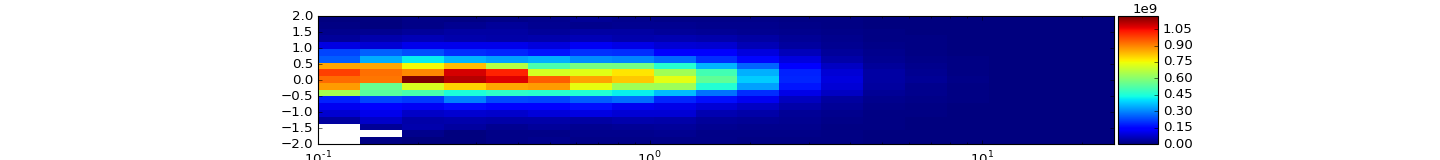

In [20]:
fig ,ax = plt.subplots(figsize=[18,2])

ax.set_xscale('log')
real = ax.imshow(sigma_st, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
divider = make_axes_locatable(ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')


In [21]:
def stars(R,z,B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    def McMBulge(U,B_0,r0,al,r_cut):
        x = np.sqrt(U[0]**2 + (U[1]/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    U = [R,z]
    return (McMBulge(U,B_0,r0,al,r_cut)+McMDisc(U[0],U[1],z_d,D_0,Rd))



R_array = (xedges[1:] + xedges[:-1])/2
Z_array = (yedges[1:] + yedges[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)

def chi2_st(B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    chi2_array =np.array([])
    expected = stars(R,Z,B_0,r0,al,r_cut,q,D_0,z_d,Rd)
    observed = dens_hist
    c = ((observed) - (expected))**2 / sigma_st**2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)# + diff**2)


def mass_check(B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    bins = 101
    edge = 20
    zedge = edge/10.
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-zedge,zedge,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * stars(U[0],U[1],B_0,r0,al,r_cut,q,D_0,z_d,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhalo.st.mass[np.where((myhalo.st.R<50.)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])
    diff = (data_in - F)**2
    return  diff

In [22]:
m1=Minuit(chi2_st, 
         B_0=8.6, error_B_0=0.01,     limit_B_0=(8,12),
         r0=1.25,    error_r0=0.01,     limit_r0=(0.01,5.),
         al=1.8,     error_al=0.01,    limit_al=(0,2.),
         r_cut=5.5,  error_r_cut=0.01,   limit_r_cut=(5,6.5),
         q=0.3,      error_q=0.01,     limit_q=(0,2.),
         D_0=2.1,    error_D_0=1e6,     limit_D_0=(0,30),
         z_d=1.8,  error_z_d=0.02,  limit_z_d=(0,6),
         Rd=100,     error_Rd=0.01,        limit_Rd=(4,20.))
#         print_level=0)
m1.migrad();

err = 0.1
upp = 1.1
low = 0.9
m2=Minuit(mass_check, 
         B_0=m1.values['B_0'], error_B_0=m1.values['B_0']*err, limit_B_0=(m1.values['B_0']*low,m1.values['B_0']*upp),
         r0=m1.values['r0'], error_r0=m1.values['r0']*err, limit_r0=(m1.values['r0']*low,m1.values['r0']*upp),
         al=m1.values['al'], error_al=m1.values['al']*err, limit_al=(m1.values['al']*low,m1.values['al']*upp),
         r_cut=m1.values['r_cut'],  error_r_cut=m1.values['r_cut']*err, limit_r_cut=(m1.values['r_cut']*low,m1.values['r_cut']*upp),
         q=m1.values['q'], error_q=m1.values['q']*err, limit_q=(m1.values['q']*low,m1.values['q']*upp),
         D_0=m1.values['D_0'], error_D_0=m1.values['D_0']*err, limit_D_0=(m1.values['D_0']*low,m1.values['D_0']*upp),
         z_d=m1.values['z_d'], error_z_d=m1.values['z_d']*err,  limit_z_d=(m1.values['z_d']*low,m1.values['z_d']*upp),
         Rd=m1.values['Rd'], error_Rd=m1.values['Rd']*err, limit_Rd=(m1.values['Rd']*low,m1.values['Rd']*upp))
#         print_level=0)

m2.migrad();

FCN = inf 
 TOTAL NCALL = 153 
 NCALLS = 153 
 
 
 EDM = nan 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 8.6 
 nan 
 0 
 0 
 8.0 
 12.0 
 
 
 
 
 2 
 r0 
 1.25 
 nan 
 0 
 0 
 0.01 
 5.0 
 
 
 
 
 3 
 al 
 1.8 
 nan 
 0 
 0 
 0.0 
 2.0 
 
 
 
 
 4 
 r_cut 
 5.5 
 nan 
 0 
 0 
 5.0 
 6.5 
 
 
 
 
 5 
 q 
 0.3 
 nan 
 0 
 0 
 0.0 
 2.0 
 
 
 
 
 6 
 D_0 
 2.1 
 nan 
 0 
 0 
 0.0 
 30.0 
 
 
 
 
 7 
 z_d 
 1.8 
 nan 
 0 
 0 
 0.0 
 6.0 
 
 
 
 
 8 
 Rd 
 20 
 nan 
 0 
 0 
 4.0 
 20.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 8.600e+00 & nan & & & 8.000e+00 & 1.200e+01 & \\
\hline
2 & r0 & 1.250e+00 & nan & & & 1.000e-02 & 5.000e+00 & \\
\hline
3 & al & 1.800e+00 & nan & & & 0.000e+00 & 2.000e+00 & \\
\hline
4 & $r_{cut}$ & 5.500e+00 & nan & & & 5.000e+00 & 6.500e+00 & \\
\hline
5 & q & 3.000e-01 & nan & & & 0.000e+00 & 2.000e+00 & \\
\hline
6 & $D_{0}$ & 2.100e+00 & nan & & & 0.000e+00 & 3.000e+01 & \\
\hline
7 & $z_{d}$ & 1.800e+00 & nan & & & 0.000e+00 & 6.000e+00 & \\
\hline
8 & Rd & 2.000e+01 & nan & & & 4.000e+00 & 2.000e+01 & \\
\hline
\end{tabular}

FCN = 4.39667039453e+19 
 TOTAL NCALL = 387 
 NCALLS = 387 
 
 
 EDM = 140433.426387 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 9.46 
 0 
 0 
 0 
 7.74 
 9.46 
 
 
 
 
 2 
 r0 
 1.375 
 0 
 0 
 0 
 1.125 
 1.375 
 
 
 
 
 3 
 al 
 1.62 
 0 
 0 
 0 
 1.62 
 1.98 
 
 
 
 
 4 
 r_cut 
 6.05 
 0 
 0 
 0 
 4.95 
 6.05 
 
 
 
 
 5 
 q 
 0.33 
 0 
 0 
 0 
 0.27 
 0.33 
 
 
 
 
 6 
 D_0 
 2.31 
 1.57652e-14 
 0 
 0 
 1.89 
 2.31 
 
 
 
 
 7 
 z_d 
 1.98 
 3.33067e-15 
 0 
 0 
 1.62 
 1.98 
 
 
 
 
 8 
 Rd 
 22 
 3.55271e-14 
 0 
 0 
 17.9999862671 
 21.9999832153 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 9.460e+00 & 0.000e+00 & & & 7.740e+00 & 9.460e+00 & \\
\hline
2 & r0 & 1.375e+00 & 0.000e+00 & & & 1.125e+00 & 1.375e+00 & \\
\hline
3 & al & 1.620e+00 & 0.000e+00 & & & 1.620e+00 & 1.980e+00 & \\
\hline
4 & $r_{cut}$ & 6.050e+00 & 0.000e+00 & & & 4.950e+00 & 6.050e+00 & \\
\hline
5 & q & 3.300e-01 & 0.000e+00 & & & 2.700e-01 & 3.300e-01 & \\
\hline
6 & $D_{0}$ & 2.310e+00 & 1.577e-14 & & & 1.890e+00 & 2.310e+00 & \\
\hline
7 & $z_{d}$ & 1.980e+00 & 3.331e-15 & & & 1.620e+00 & 1.980e+00 & \\
\hline
8 & Rd & 2.200e+01 & 3.553e-14 & & & 1.800e+01 & 2.200e+01 & \\
\hline
\end{tabular}

In [23]:
#m1.hesse()

In [24]:
#m1.minos()

In [25]:

def mass_integrated(edge):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * U[0] * stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                      m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])

    def integrand(R,z,B_0,r0,al,r_cut,q,D_0,z_d,Rd):
        return 2. * np.pi * R * stars(R,z,B_0,r0,al,r_cut,q,D_0,z_d,Rd)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                      m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd']))
    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],
                                      m1.values['q'], m1.values['D_0'], m1.values['z_d'], m1.values['Rd']))

    F = i[0] #firs level fit
    F2 = j[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhalo.st.mass[np.where((myhalo.st.R<edge)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])
get_masses = np.vectorize(mass_integrated)
get_mass_data = np.vectorize(lambda u :np.sum(myhalo.st.mass[np.where((myhalo.st.R<u)&(np.abs(myhalo.st.pos3d[:,2])<u/10.))]))


In [26]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhalo.r200),20)
level1, level2 = get_masses(r_masses)
data_mass = get_mass_data(r_masses)

<IPython.core.display.Javascript object>


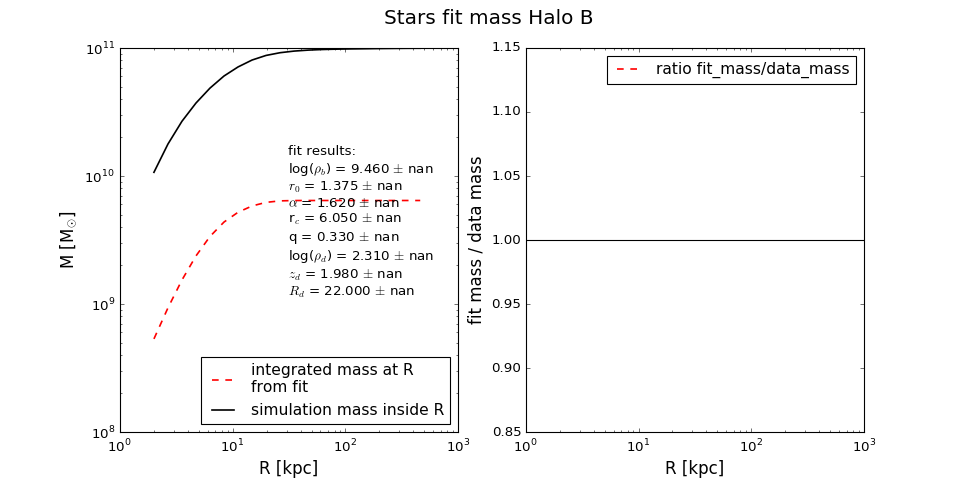

In [27]:
texto = "fit results: \n"
texto += r"log($\rho _b$) = {0:.3f} $\pm$ {1:.3f}".format(m2.values["B_0"],m1.errors["B_0"])+"\n"
texto += r"$r_0$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r0"],m1.errors["r0"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["al"],m1.errors["al"])+"\n"
texto += r"r$_c$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r_cut"],m1.errors["r_cut"])+"\n"
texto += r"q = {0:.3f} $\pm$ {1:.3f}".format(m2.values["q"],m1.errors["q"])+"\n"
texto += r"log($\rho _d$) = {0:.3f} $\pm$ {1:.3f}".format(m2.values["D_0"],m1.errors["D_0"])+"\n"
texto += r"$z_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_d"],m1.errors["z_d"])+"\n"
texto += r"$R_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["Rd"],m1.errors["Rd"])+"\n"



fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Stars fit mass Halo B",fontsize=18)
fig.text(0.3,0.35,texto,fontsize=12)
ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,level1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses,level2,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,data_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,level2/data_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,level1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

<IPython.core.display.Javascript object>


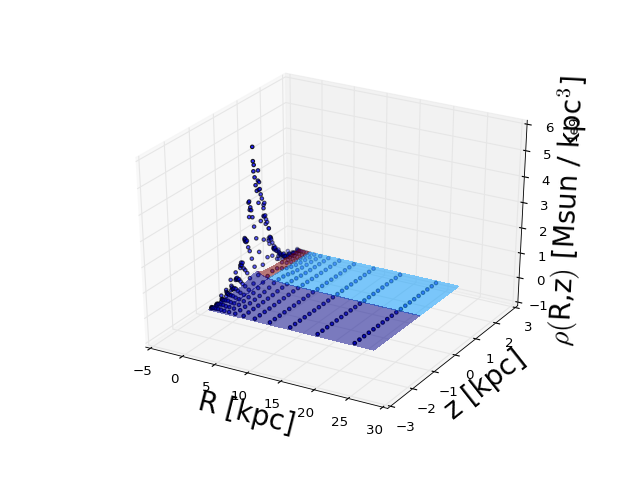

361
361
361


In [28]:

bins = stars_bins
x = xedges#np.logspace(-1,np.log10(25),bins)
y = yedges#np.linspace(-6,6,bins/2.5)
U= np.meshgrid(x, y)


#Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
#          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])
Z = stars(U[0],U[1],m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],
          m1.values['q'], m1.values['D_0'], m1.values['z_d'], m1.values['Rd'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R_test = (x[1:] + x[:-1])/2
Z_test = (y[1:] + y[:-1])/2
X,Y = np.meshgrid(R_test, Z_test)
x_s = X.reshape(1,len(X)*len(X[0]))[0]
y_s = Y.reshape(1,len(Y)*len(Y[0]))[0]
dens = dens_hist.reshape(1,len(dens_hist)*len(dens_hist[0]))[0]
print len(x_s)
print len(y_s)
print len(dens)
ax.set_xlabel("R [kpc]",fontsize=25)
my_col = cm.jet(Z/Z.max())
ax.set_ylabel("z [kpc]",fontsize=25)
ax.set_zlabel(r"$\rho($R,z$)$ [Msun / kpc$^3$]",fontsize=25)

ax.scatter(x_s, y_s,dens,marker='.',s=40)
surf = ax.plot_surface(U[0], U[1], Z, cmap=cm.coolwarm, facecolors = my_col,alpha=0.5,
                       linewidth=0, antialiased=False)

<IPython.core.display.Javascript object>


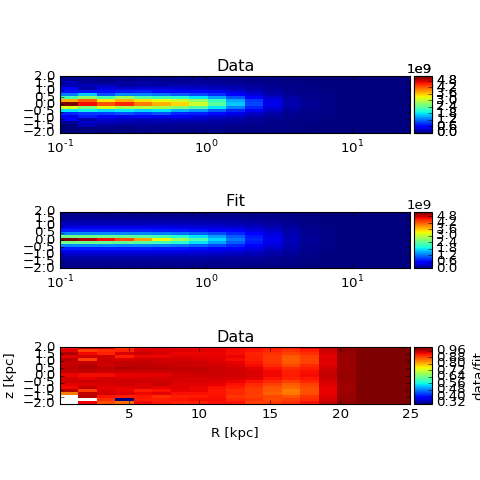

11.8739733832
0.0


In [29]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(25),bins)
y = np.linspace(-2,2,bins)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x, y)


#Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
#          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])

Z = stars(U[0],U[1],m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],
          m1.values['q'], m1.values['D_0'], m1.values['z_d'], m1.values['Rd'])

fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[6,6])

ax.set_xscale('log')
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')
fit = ax1.imshow(Z, interpolation='nearest', origin='low',
                  extent=[x[0], x[-1], y[0], y[-1]])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

ax.set_title("Data")

real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print Z.min()
print dens_hist.min()
ratio =  np.abs(Z-dens_hist)/dens_hist

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')

# Gas


In [30]:
log_hsml = np.log10(myhalo.gs.hsml.min())

In [31]:
bins=20
edge = 25
zedge = edge/15
x_gs = np.logspace(-0.5,np.log10(edge),bins)
y_gs = np.linspace(-zedge,zedge,bins)
dens_hist_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
sigma_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
for i in range(len(x_gs[:-1])):
    for j in range(len(y_gs[:-1])):
        Rcon = (myhalo.gs.R >= x_gs[i] )&(myhalo.gs.R < x_gs[i+1] )
        Zcon = (myhalo.gs.pos3d[:,2] >= y_gs[j])&(myhalo.gs.pos3d[:,2] < y_gs[j+1])
        mass = np.sum(myhalo.gs.mass[np.where(Rcon&Zcon)])
        sigma_gs[j][i] = np.std(myhalo.gs.rho[np.where(Rcon&Zcon)])
        volume = np.pi * (y_gs[j+1]-y_gs[j]) * (x_gs[i+1]**2 - x_gs[i]**2)
        dens_hist_gs [j][i] = mass / volume 
    
    


<IPython.core.display.Javascript object>


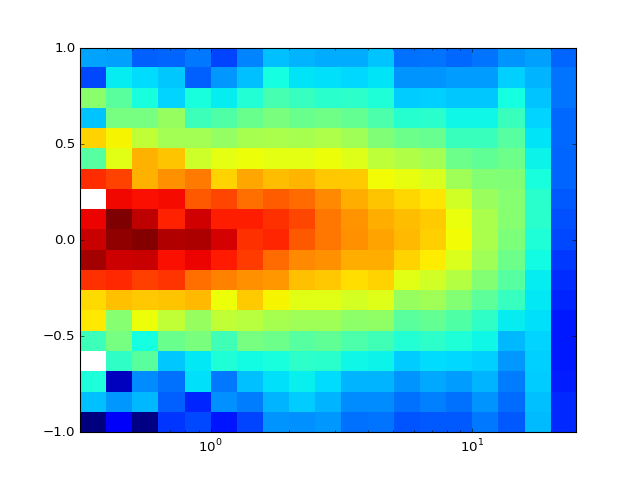

In [32]:
fig, ax = plt.subplots()
ax.set_xscale('log')
real =  plt.imshow(dens_hist_gs, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])

#cbar = plt.colorbar(real)#,orientation='horizontal')

In [33]:
#def gas(R,z,D_0,z_d,Rm,Rd):        
#    return (10**D_0) * np.exp(- (Rm / R) - (R / Rd)) / (np.cosh(z /2./ z_d))**2


def gas(R,z,D_0,z_d,Rd):
        
    return (10**D_0) * np.exp( - (R / Rd)) / (np.cosh(z /2./ z_d))**2

R_array = (x_gs[1:] + x_gs[:-1])/2
Z_array = (y_gs[1:] + y_gs[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)


def chi2_gas(D_0,z_d,Rd):
    chi2_array =np.array([])
    expected = gas(R,Z,D_0,z_d,Rd)
    observed = dens_hist_gs
    c = ((observed) - (expected))**2 / sigma_gs**2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)


def mass_check_gas(D_0,z_d,Rd):
    bins = 101
    edge = 20
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-edge/15.,edge/15.,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * gas(U[0],U[1],D_0,z_d,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhalo.gs.mass[np.where((myhalo.gs.R<edge)&(np.abs(myhalo.gs.pos3d[:,2])<edge/10.))])
    N = len(myhalo.gs.mass[np.where((myhalo.gs.R<edge)&(np.abs(myhalo.gs.pos3d[:,2])<edge/10.))])
    diff = np.abs(np.log10(data_in) - np.log10(F))
    return  diff

In [34]:
mg1=Minuit(chi2_gas, 
         D_0=12,    error_D_0=0.1,     limit_D_0=(6,15),
         z_d=.1,  error_z_d=0.001,  limit_z_d=(0.001,2),
         Rd=7.5,     error_Rd=0.01,        limit_Rd=(3,10))
mg1.migrad();

err = 0.01
upp = 1.1
low = 0.9
mg2=Minuit(mass_check_gas, 
         D_0=mg1.values['D_0'], error_D_0=mg1.values['D_0']*err, limit_D_0=(mg1.values['D_0']*low,mg1.values['D_0']*upp),
         z_d=mg1.values['z_d'], error_z_d=mg1.values['z_d']*err,  limit_z_d=(mg1.values['z_d']*low,mg1.values['z_d']*upp),
         Rd=mg1.values['Rd'], error_Rd=mg1.values['Rd']*err, limit_Rd=(mg1.values['Rd']*low,mg1.values['Rd']*upp))

mg2.migrad();

FCN = inf 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = nan 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 12 
 nan 
 0 
 0 
 6.0 
 15.0 
 
 
 
 
 2 
 z_d 
 0.1 
 nan 
 0 
 0 
 0.001 
 2.0 
 
 
 
 
 3 
 Rd 
 7.5 
 nan 
 0 
 0 
 3.0 
 10.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 1.200e+01 & nan & & & 6.000e+00 & 1.500e+01 & \\
\hline
2 & $z_{d}$ & 1.000e-01 & nan & & & 1.000e-03 & 2.000e+00 & \\
\hline
3 & Rd & 7.500e+00 & nan & & & 3.000e+00 & 1.000e+01 & \\
\hline
\end{tabular}

FCN = 1.99699967228 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 3.44597311153e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 10.8 
 1.6343 
 0 
 0 
 10.8 
 13.2 
 
 
 
 
 2 
 z_d 
 0.09 
 0.0100598 
 0 
 0 
 0.09 
 0.11 
 
 
 
 
 3 
 Rd 
 6.75 
 0.889408 
 0 
 0 
 6.75 
 8.25 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 1.080e+01 & 1.634e+00 & & & 1.080e+01 & 1.320e+01 & \\
\hline
2 & $z_{d}$ & 9.000e-02 & 1.006e-02 & & & 9.000e-02 & 1.100e-01 & \\
\hline
3 & Rd & 6.750e+00 & 8.894e-01 & & & 6.750e+00 & 8.250e+00 & \\
\hline
\end{tabular}

In [35]:

def mass_integrated_gas(edge):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * U[0] * gas(U[0],U[1],mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd'])

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg1.values['D_0'], mg1.values['z_d'], mg1.values['Rd']))

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd']))
    
    F = j[0] #firs level fit
    F2 = i[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhalo.st.mass[np.where((myhalo.st.R<edge)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])
get_masses_gs = np.vectorize(mass_integrated_gas)
get_mass_data_gs = np.vectorize(lambda u :np.sum(myhalo.gs.mass[np.where((myhalo.gs.R<u)&(np.abs(myhalo.gs.pos3d[:,2])<u/10.))]))


In [36]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhalo.r200),20)
glevel1, glevel2 = get_masses_gs(r_masses)
gdata_mass = get_mass_data_gs(r_masses)

<IPython.core.display.Javascript object>


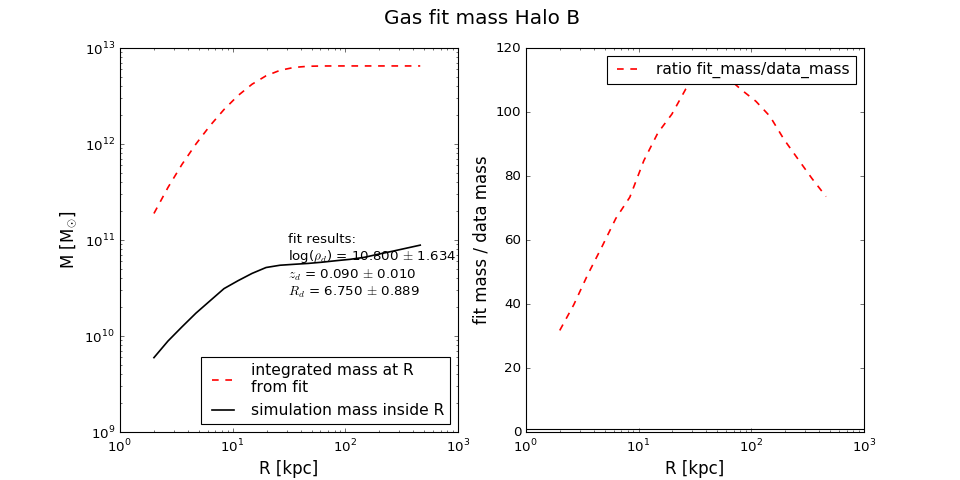

In [37]:
texto = "fit results: \n"
texto += r"log($\rho _d$) = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["D_0"],mg2.errors["D_0"])+"\n"
texto += r"$z_d$ = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["z_d"],mg2.errors["z_d"])+"\n"
texto += r"$R_d$ = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["Rd"],mg2.errors["Rd"])+"\n"

fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Gas fit mass Halo B",fontsize=18)
fig.text(0.3,0.35,texto,fontsize=12)
ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,glevel1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses,glevel2,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,gdata_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,glevel2/gdata_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,glevel1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/gasfit_haloB.pdf",dpi=300)